In [ ]:
using Pkg
pkg_folder = "../"
Pkg.activate(pkg_folder)
using BenchmarkTools
import Markdown; Base.showable(::MIME"text/markdown", ::Markdown.MD) = false # to make sth like """?replace"""  works for vscode backend, remember to choose Jupyter kernel
include(pkg_folder*"src/initialize.jl")
Threads.nthreads() #

  Activating project at `~/Realizibility_index/bnc_julia`


24

# This is the preparation for visualizing how the regimes and path changes with different structures

## Simplest example

$E + S \Longleftrightarrow C$

In [2]:
using GLMakie, GraphMakie
using GraphMakie.NetworkLayout
using Latexify

In [3]:
N = [1 1 -1]
L = L_from_N(N)
display(L)
display(N)
q_sym = [:tE,:tS]
x_sym = [:E,:S,:C]
K_sym = [:K]
model = Bnc(N=N,L=L,q_sym=q_sym,x_sym=x_sym,K_sym=K_sym)
find_all_vertices!(model)
summary(model)

2×3 Matrix{Int64}:
 1  0  1
 0  1  1

1×3 Matrix{Int64}:
 1  1  -1

---------------------Start finding all vertices, it may takes a while.--------------------
Finished, with 4 vertices found and 4 asymptotic vertices.

-------------Start calculating nullity for each vertex, it also takes a while.------------
1.Building Nρ_inv cache in parallel...
2.Calculating nullity for each vertex in parallel...
3.Storing all vertices information...
Done.
----------Binding Network Summary:-------------
Number of species (n): 3
Number of conserved quantities (d): 2
Number of reactions (r): 1
L matrix: [1 0 1; 0 1 1]
N matrix: [1 1 -1]
Direction of binding reactions: backward
Catalysis involved: No
Regimes constructed: Yes
Number of regimes: 4
  - Invertible + Asymptotic: 3
  - Singular +  Asymptotic: 1
  - Invertible +  Non-Asymptotic: 0
  - Singular +  Non-Asymptotic: 0
-----------------------------------------------


In [4]:
show_equilibrium(model; log_space=false)#|> latexify |> println 

1-element Vector{Equation}:
 K ~ (E*S) / C

In [5]:
show_conservation(model) #|> latexify |> println

2-element Vector{Equation}:
 tE ~ C + E
 tS ~ C + S

For this simple binding network, For SISO systems, we get only one possible input, tE or tS

And three possible outputs, E,S,C

Lets draw the whole binding network graph first

In [22]:
p.node_pos[]

4-element Vector{Point{2, Float32}}:
 [-1.2541476, 1.4706682]
 [-0.10283385, 0.45436367]
 [1.4556131, 0.7777548]
 [1.4513881, -1.2580786]

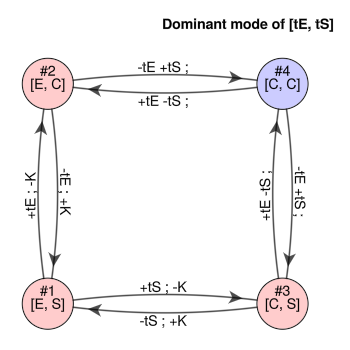

In [25]:
grh_qK_whole = get_qK_neighbor_grh(model,half=false)
edge_labels = get_edge_labels(model, sym=true, half=false) #get_edge_labels of all pairs.
f,ax,p = draw_vertices_neighbor_graph(model,grh_qK_whole; figsize=(350,350), edge_labels=edge_labels)
posi = Point2.([[-1.2,-1.2],[-1.2,1.2],[1.2,-1.2],[1.2,1.2]])
p.node_pos[] = posi
add_vertices_idx!(ax,p)
f
# save("/mnt/e/Pictures/simplest_binding_network_rgms_qK.svg", f2)

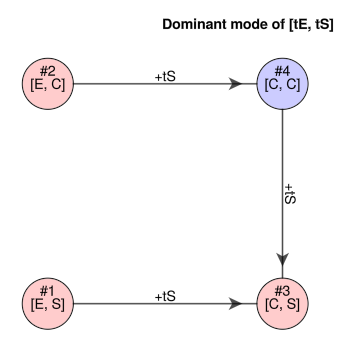

In [26]:
ch_idx =2
grh_qK_1 = get_qK_neighbor_grh(model,ch_idx)
# edge_labels = get_edge_labels(model, sym=true, half=false) #get_edge_labels of all pairs.
f2,ax2,p2 = draw_qK_neighbor_grh(model,grh_qK_1; figsize=(350,350), edge_labels="+"*repr(model.q_sym[ch_idx]))
# autolimits!(ax2)
# limits!(ax2, (-0.2,1.2), (-0.2,1.2))
p2.node_pos[] = posi
add_vertices_idx!(ax2,p2)
# bounds = find_proper_bounds_for_graph_plot(p,1.2,1.2)
# limits!(ax2, bounds...)
f2
# save("/mnt/e/Pictures/simplest_binding_network_rgms_qK_add_tS.svg", f2)

In [27]:
pths = find_all_complete_paths(model, grh_qK_1)

[ Info: sources: Set([2, 1])
[ Info: sinks: Set([3])


2-element Vector{Vector{Int64}}:
 [1, 3]
 [2, 4, 3]

In [69]:
show_interface(model,1,3,2;log_space=false)

tS ~ K

In [72]:
show_expression_x(model,3)

3-element Vector{Equation}:
 log10(E) ~ -log10(tS) + log10(tE) + log10(K)
 log10(S) ~ log10(tS)
 log10(C) ~ log10(tE)

In [82]:
get_expression_for_path(model, pths[1], ch_idx,3)[1]

2-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 (tE*tS) / K
 tE

In [83]:
conds = find_conditions_for_pathes(model, pths, ch_idx)

2-element Vector{Polyhedron}:
 HalfSpace([1.0, -1.0], 0.0)
 HalfSpace([-1.0, 1.0], 0.0)

In [84]:
show_condition_poly(model,conds[1],ch_idx, log_space=false)

syms = Num[tE, K]


1-element Vector{Num}:
 K > tE

[ Info: Change in logtS
[ Info: parameters: Pair{Num, Int64}[tE => 3, K => 0]
[ Info: Target syms contains: logE 
[ Info: Target syms contains: logS 
[ Info: Target syms contains: logC 


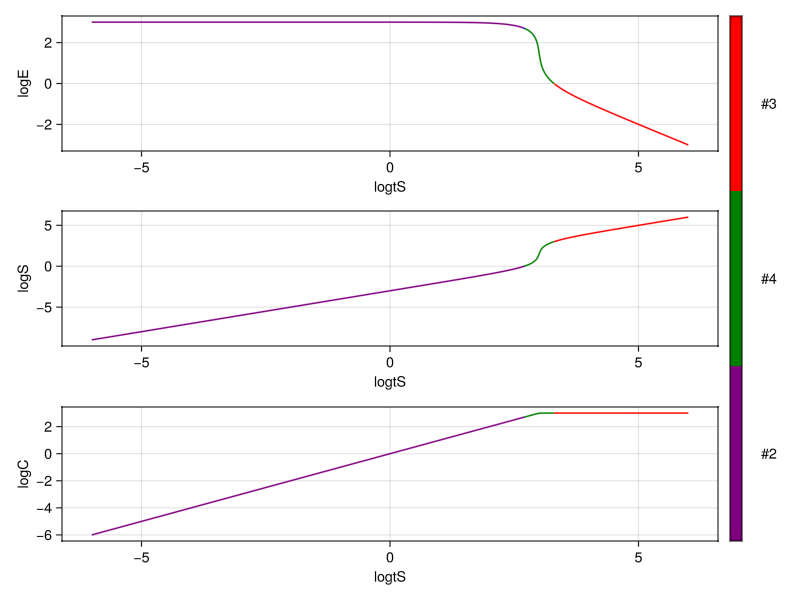

In [95]:
SISO_plot(model, [3,0], ch_idx; start=-6, stop=6, npoints=1000)

In [262]:
ord_E = find_reaction_order_for_pathes(model,pths,ch_idx,1)
ord_S = find_reaction_order_for_pathes(model,pths,ch_idx,2)
ord_C = find_reaction_order_for_pathes(model,pths,ch_idx,3)

2-element Vector{Vector{<:Real}}:
 [1.0, 0.0, 0.0]
 [1.0, 0.0]

In [294]:
render_arrow.(ord_C)

2-element Vector{String}:
 "1 → 0 → 0"
 "1 → 0"

## Case 2 competitive binding

In [109]:
N = [1 1 0 -1 0
     1 0 1  0 -1]
L = L_from_N(N)
x_sym = [:E,:S,:P,:Cs,:Cp]
q_sym = [:tE,:tS,:tP]
K_sym = [:Ks, :Kp]
model = Bnc(N=N,L=L,q_sym=q_sym,x_sym=x_sym,K_sym=K_sym)

Bnc{Int8}([1 1 … -1 0; 1 0 … 0 -1], [1 0 … 1 1; 0 1 … 1 0; 0 0 … 0 1], 2, 5, 3, Num[E, S, P, Cs, Cp], Num[tE, tS, tP], Num[Ks, Kp], nothing, Vector{Int8}[], Dict{Vector{Int8}, Int64}(), Bool[], Int8[], nothing, Vertex[], Bool[], false, Dict{Vector{Int8}, Tuple{SparseMatrixCSC{Float64, Int64}, Int8}}(), 1, [0.0, 0.0, 0.0, 0.0, 0.0], [0.47712125471966244, 0.3010299956639812, 0.3010299956639812, 0.0, 0.0], false, sparse([1, 2, 3, 1, 2, 1, 3], [1, 2, 3, 4, 4, 5, 5], [1, 1, 1, 1, 1, 1, 1], 3, 5), sparse([1, 2, 3, 1, 2, 1, 3], [1, 2, 3, 4, 4, 5, 5], [1, 1, 1, 1, 1, 1, 1], 3, 5), [[1, 4, 5], [2, 4], [3, 5]], [1, 3, 4, 5], sparse([1, 2, 1, 2, 1, 2], [1, 1, 2, 3, 4, 5], [1, 1, 1, 1, -1, -1], 2, 5), sparse([1, 4, 5, 2, 4, 3, 5, 1, 2, 4, 1, 3, 5], [1, 1, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 5], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0], 5, 5), [1, 4, 6, 8, 9, 11, 12], [1, 2, 3, 1, 2, 1, 3], [1, 2, 3, 4, 4, 5, 5], [2, 3, 5, 7, 10, 13], [4, 5, 4, 5, 4, 5], [1, 1, 2, 3, 4, 5], [1,

In [97]:
show_equilibrium(model;log_space=false)# |> latexify |> println

2-element Vector{Equation}:
 Ks ~ (E*S) / Cs
 Kp ~ (E*P) / Cp

In [98]:
show_conservation(model)# |> latexify |> println

3-element Vector{Equation}:
 tE ~ Cp + Cs + E
 tS ~ Cs + S
 tP ~ Cp + P

In [99]:
find_all_vertices!(model)
summary(model)

---------------------Start finding all vertices, it may takes a while.--------------------
Finished, with 12 vertices found and 12 asymptotic vertices.

-------------Start calculating nullity for each vertex, it also takes a while.------------
1.Building Nρ_inv cache in parallel...
2.Calculating nullity for each vertex in parallel...
3.Storing all vertices information...
Done.
----------Binding Network Summary:-------------
Number of species (n): 5
Number of conserved quantities (d): 3
Number of reactions (r): 2
L matrix: [1 0 0 1 1; 0 1 0 1 0; 0 0 1 0 1]
N matrix: [1 1 0 -1 0; 1 0 1 0 -1]
Direction of binding reactions: forward
Catalysis involved: No
Regimes constructed: Yes
Number of regimes: 12
  - Invertible + Asymptotic: 8
  - Singular +  Asymptotic: 4
  - Invertible +  Non-Asymptotic: 0
  - Singular +  Non-Asymptotic: 0
-----------------------------------------------


---------------------Start finding all vertices, it may takes a while.--------------------
Finished, with 12 vertices found and 12 asymptotic vertices.

-------------Start calculating nullity for each vertex, it also takes a while.------------
1.Building Nρ_inv cache in parallel...
2.Calculating nullity for each vertex in parallel...
3.Storing all vertices information...
Done.
----------------Start calculating vertices neighbor graph, It may takes a while.----------------
Done.

-------Start calculating vertices neighbor graph with qK change dir, It may takes a while.------------
Done.



[ Info: All regimes converged after 6100000 samples.
[ Info: Total samples: 6100000, Elapsed: 1.4 s


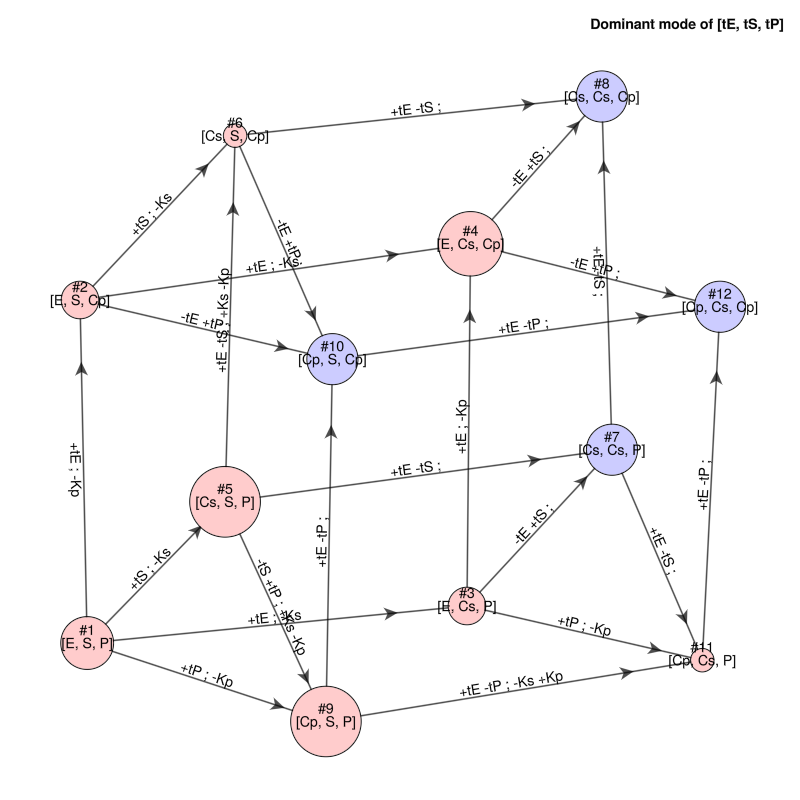

In [110]:
grh_qK_whole = get_qK_neighbor_grh(model)
edge_labels = get_edge_labels(model, sym=true) #get_edge_labels of all pairs.
f2,ax2,p2 = draw_qK_neighbor_grh(model,grh_qK_whole; figsize=(800,800), 
        edge_labels=edge_labels)
add_vertices_idx!(ax2,p2)
f2

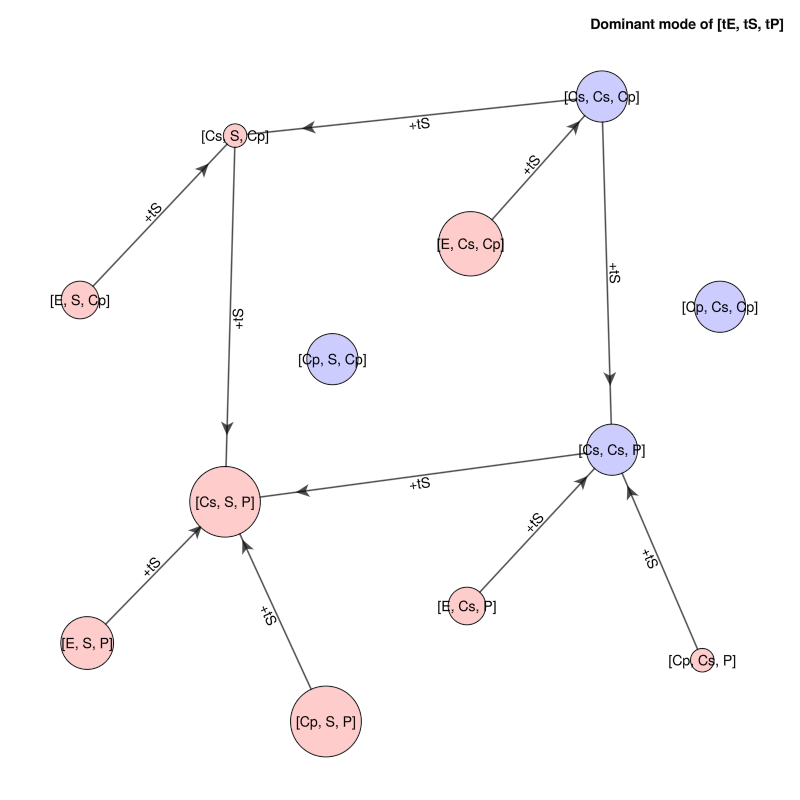

In [104]:
ch_idx_2=2
grh_qK_2 = get_qK_neighbor_grh(model,ch_idx_2)
# edge_labels = get_edge_labels(model, sym=true, half=false) #get_edge_labels of all pairs.
f2,ax2,p2 = draw_qK_neighbor_grh(model,grh_qK_2; 
            figsize=(800,800), 
            edge_labels="+"*repr(model.q_sym[ch_idx_2]))
f2

In [105]:
pths = find_all_complete_paths(model, grh_qK_2)
render_arrow.(pths,"#") .|>  println
display(model.x_sym[ch_idx_2])

[ Info: sources: Set([4, 2, 11, 9, 3, 1])
[ Info: sinks: Set([5])


#1 → #5
#2 → #6 → #5
#3 → #7 → #5
#4 → #8 → #6 → #5
#4 → #8 → #7 → #5
#9 → #5
#11 → #7 → #5


S

In [106]:
conds = find_conditions_for_pathes(model, pths, ch_idx_2)

7-element Vector{Polyhedron}:
 HalfSpace([-0.0, 1.0, -0.0, -1.0], 0.0) ∩ HalfSpace([1.0, -0.0, -1.0, -0.0], 0.0) ∩ HalfSpace([1.0, -0.0, -0.0, -1.0], 0.0)
 HalfSpace([1.0, -0.0, -1.0, -0.0], 0.0) ∩ HalfSpace([-1.0, -0.0, -0.0, 1.0], 0.0) ∩ HalfSpace([-1.0, 1.0, -0.0, -0.0], 0.0)
 HalfSpace([-0.0, 1.0, -0.0, -1.0], 0.0) ∩ HalfSpace([1.0, -0.0, -0.0, -1.0], 0.0) ∩ HalfSpace([-1.0, -0.0, 1.0, -0.0], 0.0)
 HalfSpace([-1.0, -0.0, 1.0, -0.0], 0.0) ∩ HalfSpace([-1.0, 1.0, -0.0, -0.0], 0.0) ∩ HalfSpace([-0.0, -0.0, -1.0, 1.0], 0.0)
 HalfSpace([-1.0, -0.0, -0.0, 1.0], 0.0) ∩ HalfSpace([-1.0, 1.0, -0.0, -0.0], 0.0) ∩ HalfSpace([-0.0, -0.0, 1.0, -1.0], 0.0)
 HalfSpace([-0.0, -1.0, -0.0, 1.0], 0.0) ∩ HalfSpace([1.0, -1.0, -1.0, 1.0], 0.0) ∩ HalfSpace([1.0, -1.0, -0.0, -0.0], 0.0)
 HalfSpace([-0.0, -1.0, -0.0, 1.0], 0.0) ∩ HalfSpace([1.0, -1.0, -0.0, -0.0], 0.0) ∩ HalfSpace([-1.0, 1.0, 1.0, -1.0], 0.0)

In [108]:
V_conds = calc_volume(conds;asymptotic=true).|> x->x[1]
V_conds .|> x->round(x, digits=3)

length(full_dim_idx) = 7


[ Info: All regimes converged after 3600000 samples.
[ Info: Total samples: 3600000, Elapsed: 0.58 s


7-element Vector{Float64}:
 0.208
 0.083
 0.125
 0.125
 0.125
 0.292
 0.042

In [ ]:
idx_tmp = 2
println("input: "* repr(model.x_sym[ch_idx_2]))
println("output: "* repr(model.x_sym[idx_tmp]))
ord_pth = find_reaction_order_for_pathes(model, pths, ch_idx_2, idx_tmp)
render_arrow.(ord_pth) .|> println

input: S
output: S
1 → 1
1 → 1 → 1
1 → Inf → 1
1 → Inf → 1 → 1
1 → Inf → Inf → 1
1 → 1
1 → Inf → 1


7-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

In [ ]:
ord_pth_ = find_reaction_order_for_pathes(model, pths, ch_idx_2, idx_tmp,deduplicate=true)
m = group_sum(ord_pth_, V_conds)
for (k,v) in m
    print(render_arrow(k))
    print("\t")
    println(round(v, digits=3))
end

0.208
0.083
0.125
0.125
0.125
0.292
0.042
input: S
output: E
0 → -1	0.583
0 → -Inf → -1	0.417


In [311]:
show_condition_poly(model,conds[6], ch_idx_2;log_space=false) |> latexify |> print

syms = Num[tE, tP, Ks, Kp]
\begin{equation}
\left[
\begin{array}{c}
\mathtt{tP} > \mathtt{Kp} \\
\mathtt{Ks} \mathtt{tP} > \mathtt{Kp} \mathtt{tE} \\
\mathtt{tP} > \mathtt{tE} \\
\end{array}
\right]
\end{equation}


In [197]:
edgetype(a)

Graphs.SimpleGraphs.SimpleEdge{Int64}

In [199]:
Edge(3,1) |> typeof

Graphs.SimpleGraphs.SimpleEdge{Int64}

LoadError: UndefVarError: `grh` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [328]:
add_C = [-1 0 0 1 0
         -1 0 0 0 1] #tE < Ks, tE < Kp
add_C0 = [-0.1; -0.1]
nullity = 0

perm_valid = feasible_vertieces_with_constraint(model, add_C, add_C0, nullity; return_idx=true)

dim(ins) = 5
dim(ins) = 0
dim(ins) = 0
dim(ins) = 0
dim(ins) = 5
dim(ins) = 0
dim(ins) = 0
dim(ins) = 0
dim(ins) = 5
dim(ins) = 0
dim(ins) = 0
dim(ins) = 0


3-element Vector{Int64}:
 1
 5
 9

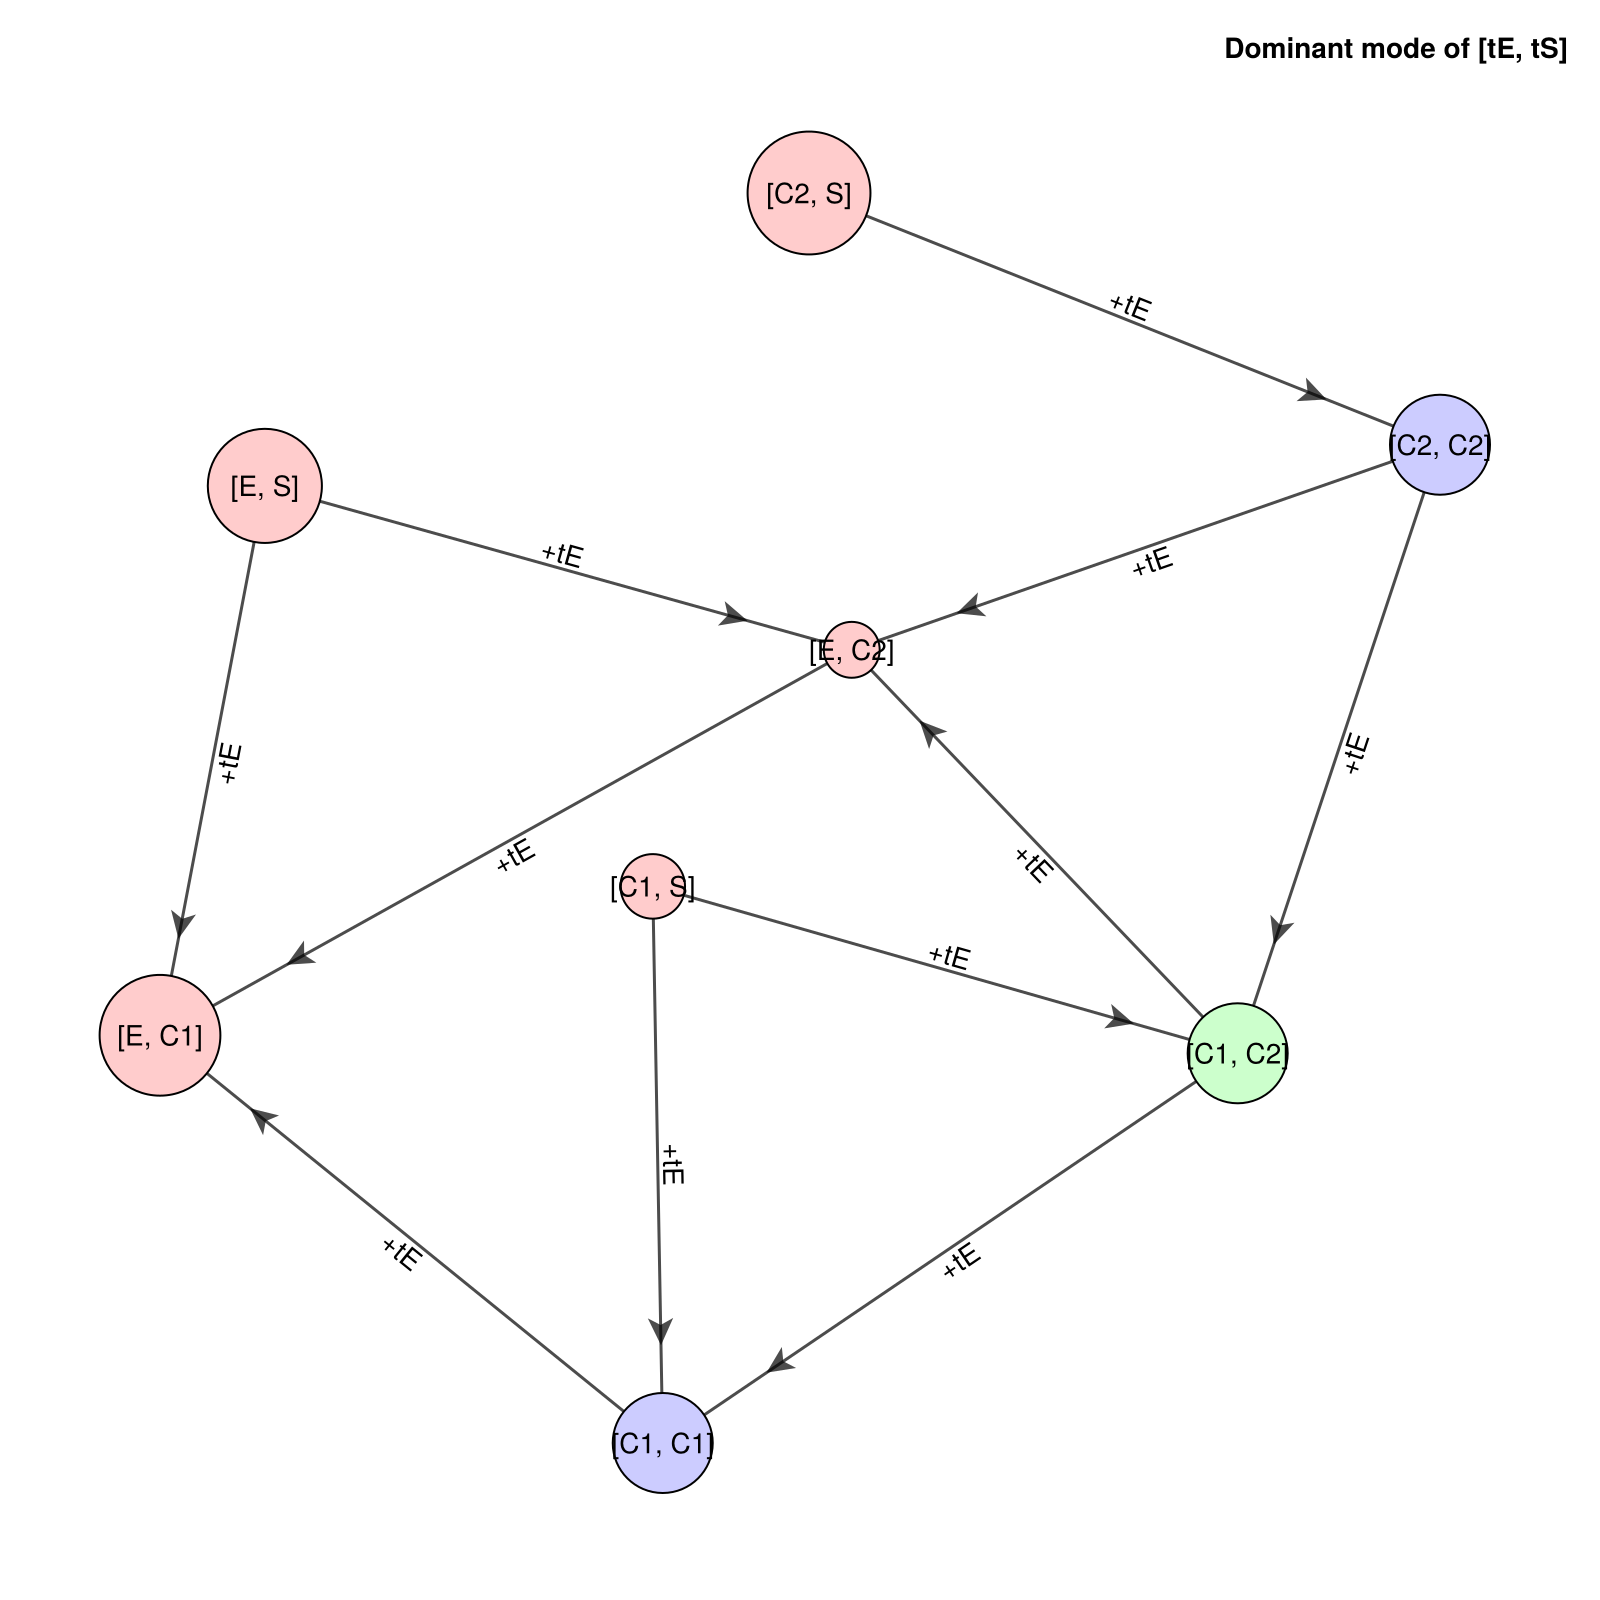

CairoMakie.Screen{IMAGE}


In [451]:
ch_idx_1=1
grh_qK_1 = get_qK_neighbor_grh(model,ch_idx_1)
# edge_labels = get_edge_labels(model, sym=true, half=false) #get_edge_labels of all pairs.
f2,ax2,p2 = draw_qK_neighbor_grh(model,grh_qK_1; 
            figsize=(800,800), 
            edge_labels="+"*repr(model.q_sym[ch_idx_1]),
            node_size=V)
p2.node_pos[] = posi
limits!(ax2, bounds...)
display(f2)

In [331]:
pths = find_all_complete_paths(model, grh_qK_1)
render_arrow.(pths,"#") .|>  println
display(model.x_sym[ch_idx_1])

sources = Set([5, 9, 1])
sinks = Set([4])
#1 → #2 → #4
#1 → #3 → #4
#5 → #6 → #8 → #4
#5 → #7 → #3 → #4
#5 → #7 → #8 → #4
#5 → #7 → #11 → #12 → #4
#9 → #10 → #2 → #4
#9 → #10 → #6 → #8 → #4
#9 → #10 → #12 → #4
#9 → #11 → #12 → #4


E

In [ ]:
conds = find_conditions_for_pathes(model, pths, ch_idx_1)

10-element Vector{Polyhedron}:
 HalfSpace([1.0, -0.0, -1.0, -0.0], 0.0) ∩ HalfSpace([-0.0, 1.0, -0.0, -1.0], 0.0) ∩ HalfSpace([-0.0, -0.0, -1.0, 1.0], 0.0)
 HalfSpace([1.0, -0.0, -1.0, -0.0], 0.0) ∩ HalfSpace([-0.0, -0.0, 1.0, -1.0], 0.0) ∩ HalfSpace([-0.0, 1.0, -0.0, -1.0], 0.0)
 HalfSpace([-0.0, -0.0, -1.0, 1.0], 0.0) ∩ HalfSpace([-1.0, 1.0, 1.0, -1.0], 0.0) ∩ HalfSpace([-1.0, -0.0, 1.0, -0.0], 0.0)
 HalfSpace([-0.0, 1.0, -0.0, -1.0], 0.0) ∩ HalfSpace([-1.0, -0.0, 1.0, -0.0], 0.0) ∩ HalfSpace([1.0, -0.0, -0.0, -1.0], 0.0)
 HalfSpace([-0.0, -0.0, 1.0, -1.0], 0.0) ∩ HalfSpace([-1.0, -0.0, -0.0, 1.0], 0.0) ∩ HalfSpace([-1.0, 1.0, -0.0, -0.0], 0.0)
 HalfSpace([-1.0, 1.0, 1.0, -1.0], 0.0) ∩ HalfSpace([1.0, -1.0, -0.0, -0.0], 0.0) ∩ HalfSpace([-0.0, -1.0, -0.0, 1.0], 0.0)
 HalfSpace([-0.0, -1.0, -0.0, 1.0], 0.0) ∩ HalfSpace([1.0, -0.0, -1.0, -0.0], 0.0) ∩ HalfSpace([-0.0, 1.0, -1.0, -0.0], 0.0)
 HalfSpace([1.0, -1.0, -1.0, 1.0], 0.0) ∩ HalfSpace([-1.0, -0.0, 1.0, -0.0], 0.0) ∩ HalfSpace([-

In [335]:
V_conds = calc_volume(conds;asymptotic=true,N=1000_0000).|> x->x[1]
V_conds .|> x->round(x, digits=3)|>println

total_counts = [1251060, 1250115, 833526, 1248530, 1248202, 416167, 1249343, 417497, 1251244, 834316]
0.125
0.125
0.083
0.125
0.125
0.042
0.125
0.042
0.125
0.083


10-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

In [336]:
ord_pth = find_reaction_order_for_pathes(model, pths, ch_idx_2, idx_tmp)
render_arrow.(ord_pth) .|> println

0 → 0 → 0
0 → 0 → 0
-1 → -1 → -Inf → 0
-1 → -Inf → 0 → 0
-1 → -Inf → -Inf → 0
-1 → -Inf → 0 → 0 → 0
0 → 0 → 0 → 0
0 → 0 → -1 → -Inf → 0
0 → 0 → 0 → 0
0 → 0 → 0 → 0


10-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

In [354]:
idx_tmp = 4


println("input: "* repr(model.q_sym[ch_idx_1]))
println("output: "* repr(model.x_sym[idx_tmp]))
ord_pth = find_reaction_order_for_pathes(model, pths, ch_idx_1, idx_tmp)
render_arrow.(ord_pth) .|> println

input: tE
output: Cs
1 → 1 → 0
1 → 0 → 0
1 → 1 → 0 → 0
1 → 0 → 0 → 0
1 → 0 → 0 → 0
1 → 0 → 0 → 0 → 0
1 → Inf → 1 → 0
1 → Inf → 1 → 0 → 0
1 → Inf → 0 → 0
1 → 0 → 0 → 0


10-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

In [355]:
ord_pth_ = find_reaction_order_for_pathes(model, pths, ch_idx_1, idx_tmp,deduplicate=true)
m = group_sum(ord_pth_, V_conds)
for (k,v) in m
    print(render_arrow(k))
    print("\t")
    println(round(v, digits=3))
end

1 → 0	0.708
1 → Inf → 1 → 0	0.167
1 → Inf → 0	0.125


Some illustrative plot examples

In [374]:
pths[6]

5-element Vector{Int64}:
  5
  7
 11
 12
  4

In [395]:
show_condition_poly(model,conds[6], ch_idx_1;log_space=false) |> latexify |> print

syms = Num[tS, tP, Ks, Kp]
\begin{equation}
\left[
\begin{array}{c}
\mathtt{Kp} \mathtt{tS} > \mathtt{Ks} \mathtt{tP} \\
\mathtt{tP} > \mathtt{tS} \\
\mathtt{tP} > \mathtt{Kp} \\
\end{array}
\right]
\end{equation}


In [426]:
cond_s

4-element Vector{Float64}:
  0.0
  2.2961005941905386
 -5.54327719506772
  0.0

syms = Num[tS, tP, Ks, Kp]


3-element Vector{Num}:
 (Kp*tS) > (Ks*tP)
           tP > tS
           tP > Kp

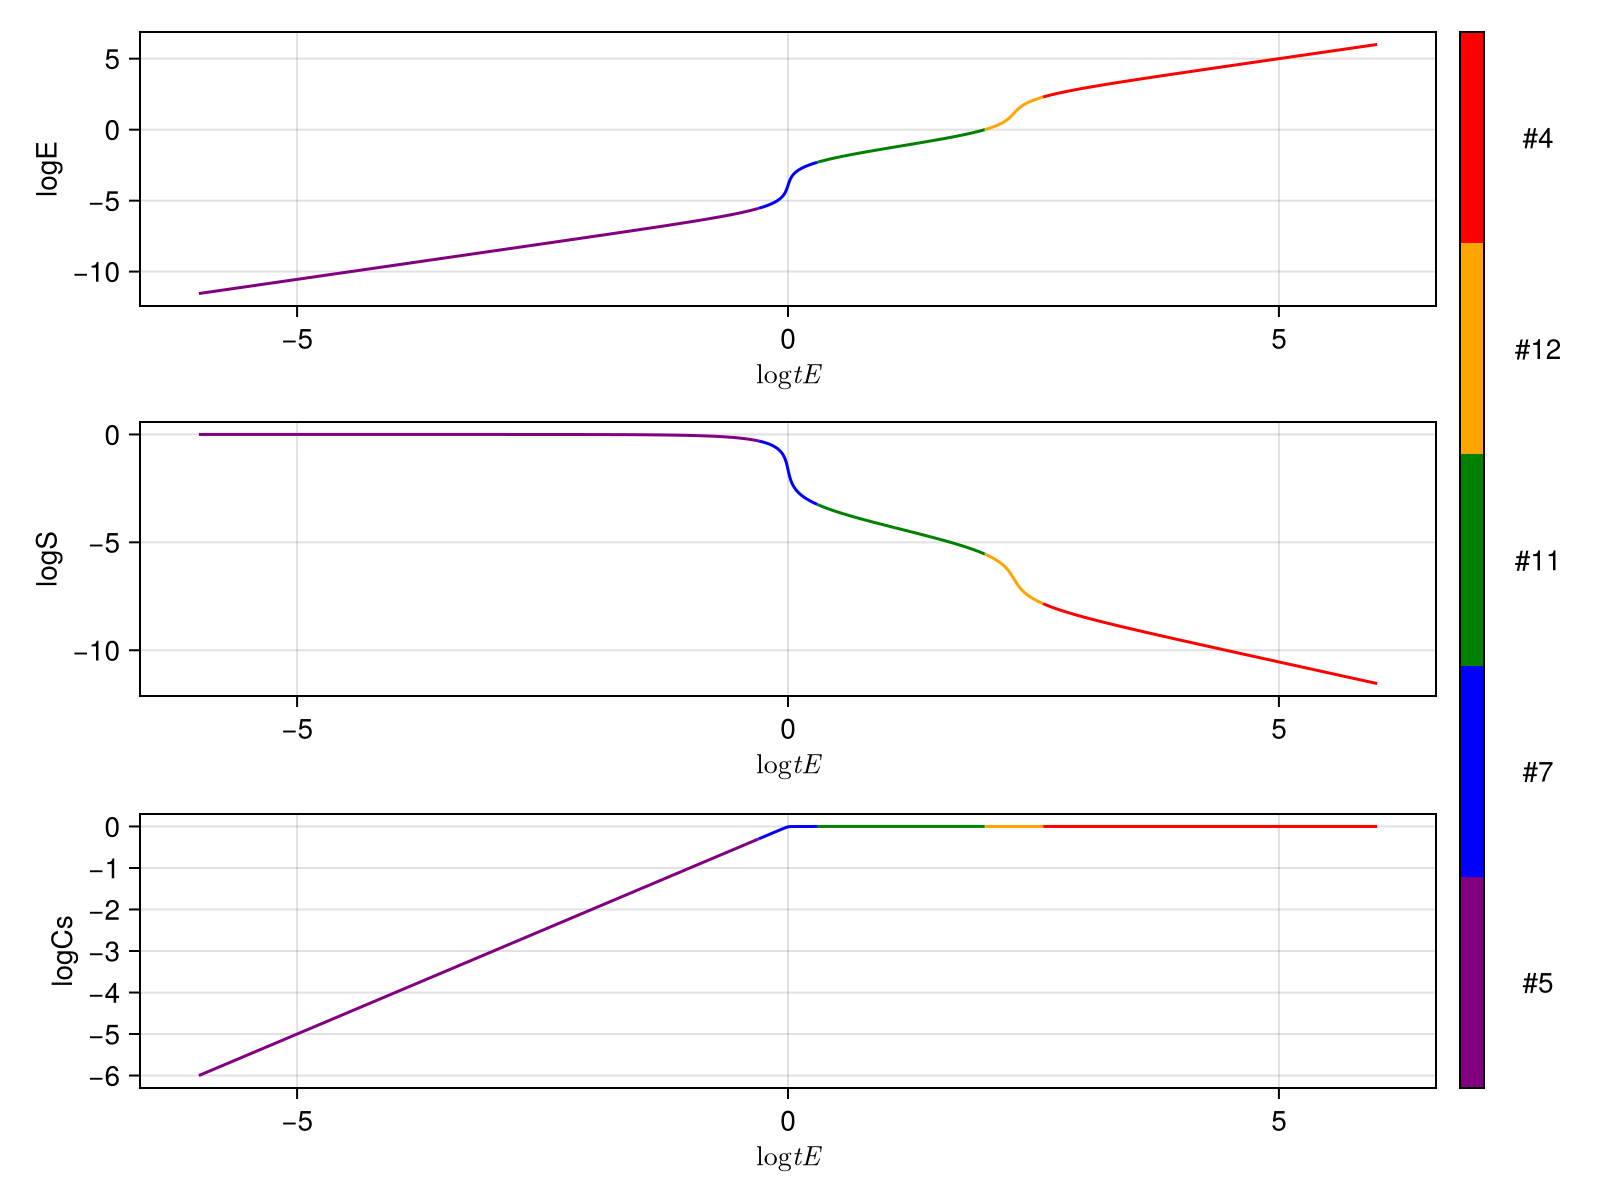

CairoMakie.Screen{IMAGE}


In [411]:
cond_s = get_one_inner_point(conds[6],extend=6,rand_line=false, rand_ray=false)
display(show_condition_poly(model,conds[6], ch_idx_1;log_space=false))
change_S = range(-6,6,1000)

start_logqK = [-6;cond_s]
end_logqK = [6;cond_s]
logx = x_traj_with_qK_change(model, start_logqK, end_logqK;input_logspace=true, output_logspace=true, tstops = range(0,1,1000), saveat = range(0,1,1000))

#assign color
rgm = logx[2] .|> x-> assign_vertex_x(model, x;input_logspace=true) |> x->get_idx(model,x)

unique_rgm = unique(rgm)
col_map_dict = Dict(unique_rgm[i]=>i for i in 1:length(unique_rgm))
crange =(1, length(unique_rgm))
cmap = :rainbow
nlevels = crange[2]-crange[1] + 1
cmap_disc = cgrad(cmap, nlevels, categorical=true)

F = Figure(size = (800,600))
for (i, j) in enumerate([1,2,4])
    ax = Axis(F[i,1]; xlabel = L"\log tE", ylabel = "log"*repr(model.x_sym[j]))
    lines!(ax, change_S, logx[2] .|> x-> x[j]; color = map(r->col_map_dict[r], rgm), colorrange = crange, colormap = cmap)
end
Colorbar(F[:,end+1], colorrange = crange, colormap = cmap_disc,ticks=[0])

# add perm label
ax = Axis(F[:,end+1])
hidexdecorations!(ax)
hideydecorations!(ax)
hidespines!(ax)
colsize!(F.layout,3,Fixed(30))
colsize!(F.layout,2,Fixed(0))

for i in eachindex(unique_rgm)
    y_pos = (i - 0.5)*(1/length(unique_rgm))
    text!(ax, Point2f(0.5,y_pos); text = "#"*string(unique_rgm[i]), align = (:center, :center), color = :black)
end
ylims!(ax, (0,1))

display(F)

In [412]:
save("/mnt/e/Pictures/Competitive_binding_network_rgms_traj_57124.svg", F)

CairoMakie.Screen{SVG}


## Case 3: cooperative binding

In [194]:

N= [1 1 -1 0
    0 1  1 -1]
L = L_from_N(N)
x_sym = [:E,:S,:C1,:C2]
q_sym = [:tE,:tS]
K_sym = [:K1,:K2]
model = Bnc(N=N,L=L,q_sym=q_sym,x_sym=x_sym,K_sym=K_sym)
find_all_vertices!(model)
summary(model)

---------------------Start finding all vertices, it may takes a while.--------------------
Finished, with 8 vertices found and 7 asymptotic vertices.

-------------Start calculating nullity for each vertex, it also takes a while.------------
1.Building Nρ_inv cache in parallel...
2.Calculating nullity for each vertex in parallel...
3.Storing all vertices information...
Done.
----------Binding Network Summary:-------------
Number of species (n): 4
Number of conserved quantities (d): 2
Number of reactions (r): 2
L matrix: [1 0 1 1; 0 1 1 2]
N matrix: [1 1 -1 0; 0 1 1 -1]
Direction of binding reactions: forward
Catalysis involved: No
Regimes constructed: Yes
Number of regimes: 8
  - Invertible + Asymptotic: 5
  - Singular +  Asymptotic: 2
  - Invertible +  Non-Asymptotic: 1
  - Singular +  Non-Asymptotic: 0
-----------------------------------------------


In [414]:
show_equilibrium(model;log_space=false) |> latexify |> println
show_conservation(model) |> latexify |> println

\begin{equation}
\left[
\begin{array}{c}
\mathtt{K1} = \frac{E S}{\mathtt{C1}} \\
\mathtt{K2} = \frac{\mathtt{C1} S}{\mathtt{C2}} \\
\end{array}
\right]
\end{equation}

\begin{align}
\mathtt{tE} &= \mathtt{C1} + \mathtt{C2} + E \\
\mathtt{tS} &= \mathtt{C1} + 2 \mathtt{C2} + S
\end{align}



In [415]:
find_all_vertices!(model)
summary(model)

---------------------Start finding all vertices, it may takes a while.--------------------
Finished, with 8 vertices found and 7 asymptotic vertices.

-------------Start calculating nullity for each vertex, it also takes a while.------------
1.Building Nρ_inv cache in parallel...
2.Calculating nullity for each vertex in parallel...
3.Storing all vertices information...
Done.
----------Binding Network Summary:-------------
Number of species (n): 4
Number of conserved quantities (d): 2
Number of reactions (r): 2
Direction of binding reactions: forward
Catalysis involved: No
Regimes constructed: Yes
Number of regimes: 8
  - Invertible + Asymptotic: 5
  - Singular +  Asymptotic: 2
  - Invertible +  Non-Asymptotic: 1
  - Singular +  Non-Asymptotic: 0
-----------------------------------------------


In [434]:
sum(V_regimes)

1.000000576218602

In [432]:
V_regimes = calc_volume(model;asymptotic=true,N=10000000) .|> x->x[1] 
["#"*repr(i=>round(V_regimes[i], digits=3)) for i in 1:length(V_regimes)] |> sort .|> println

total_counts = [2606093, 2916510, 624259, 832699, 3020439]
#1 => 0.261
#2 => 0.292
#3 => 0.062
#4 => 0.083
#5 => 0.0
#6 => 0.0
#7 => 0.302
#8 => 0.0


8-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

In [7]:
V = get_node_size(model,50,N=10000000)

total_counts = [2602701, 2916952, 625566, 833690, 3021091]


Dict{Int64, Float64} with 8 entries:
  5 => 50.0
  4 => 32.2818
  6 => 50.0
  7 => 61.4521
  2 => 60.3837
  8 => 50.0
  3 => 27.9635
  1 => 57.0384

In [442]:
model.L

2×4 Matrix{Int64}:
 1  0  1  1
 0  1  1  2

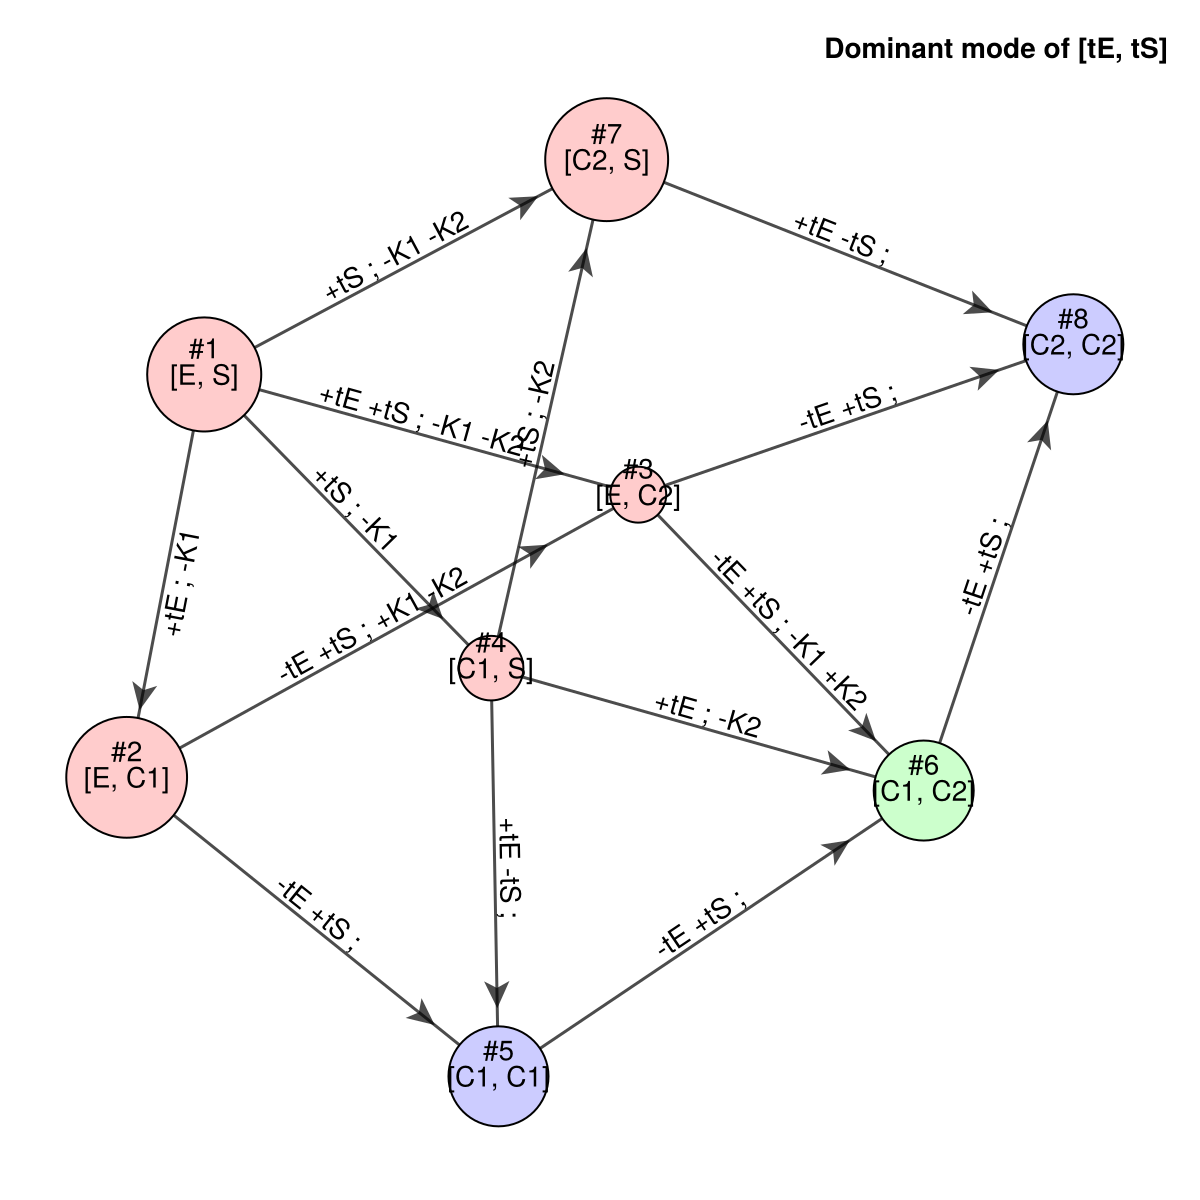

CairoMakie.Screen{IMAGE}


In [ ]:
#get nodes posi from x space neighbor
grh_temp = get_x_neighbor_grh(model)
f2,ax2,p2 = draw_vertices_neighbor_graph(model, grh_temp; figsize=(800,800))
posi = p2.node_pos[]

# draw plot
grh_qK_whole = get_qK_neighbor_grh(model,half=true)
edge_labels = get_edge_labels(model, sym=true, half=false) #get_edge_labels of all pairs.
f2,ax2,p2 = draw_qK_neighbor_grh(model,grh_qK_whole; figsize=(600,600), 
        edge_labels=edge_labels,
        node_size=V)
p2.node_pos[] = posi

bounds = find_proper_bounds_for_graph_plot(p2)
limits!(ax2, bounds...)
add_vertices_idx!(ax2,p2)

display(f2)
# save("/mnt/e/Pictures/Sequential_binding_network_rgms_qK.svg", f2)

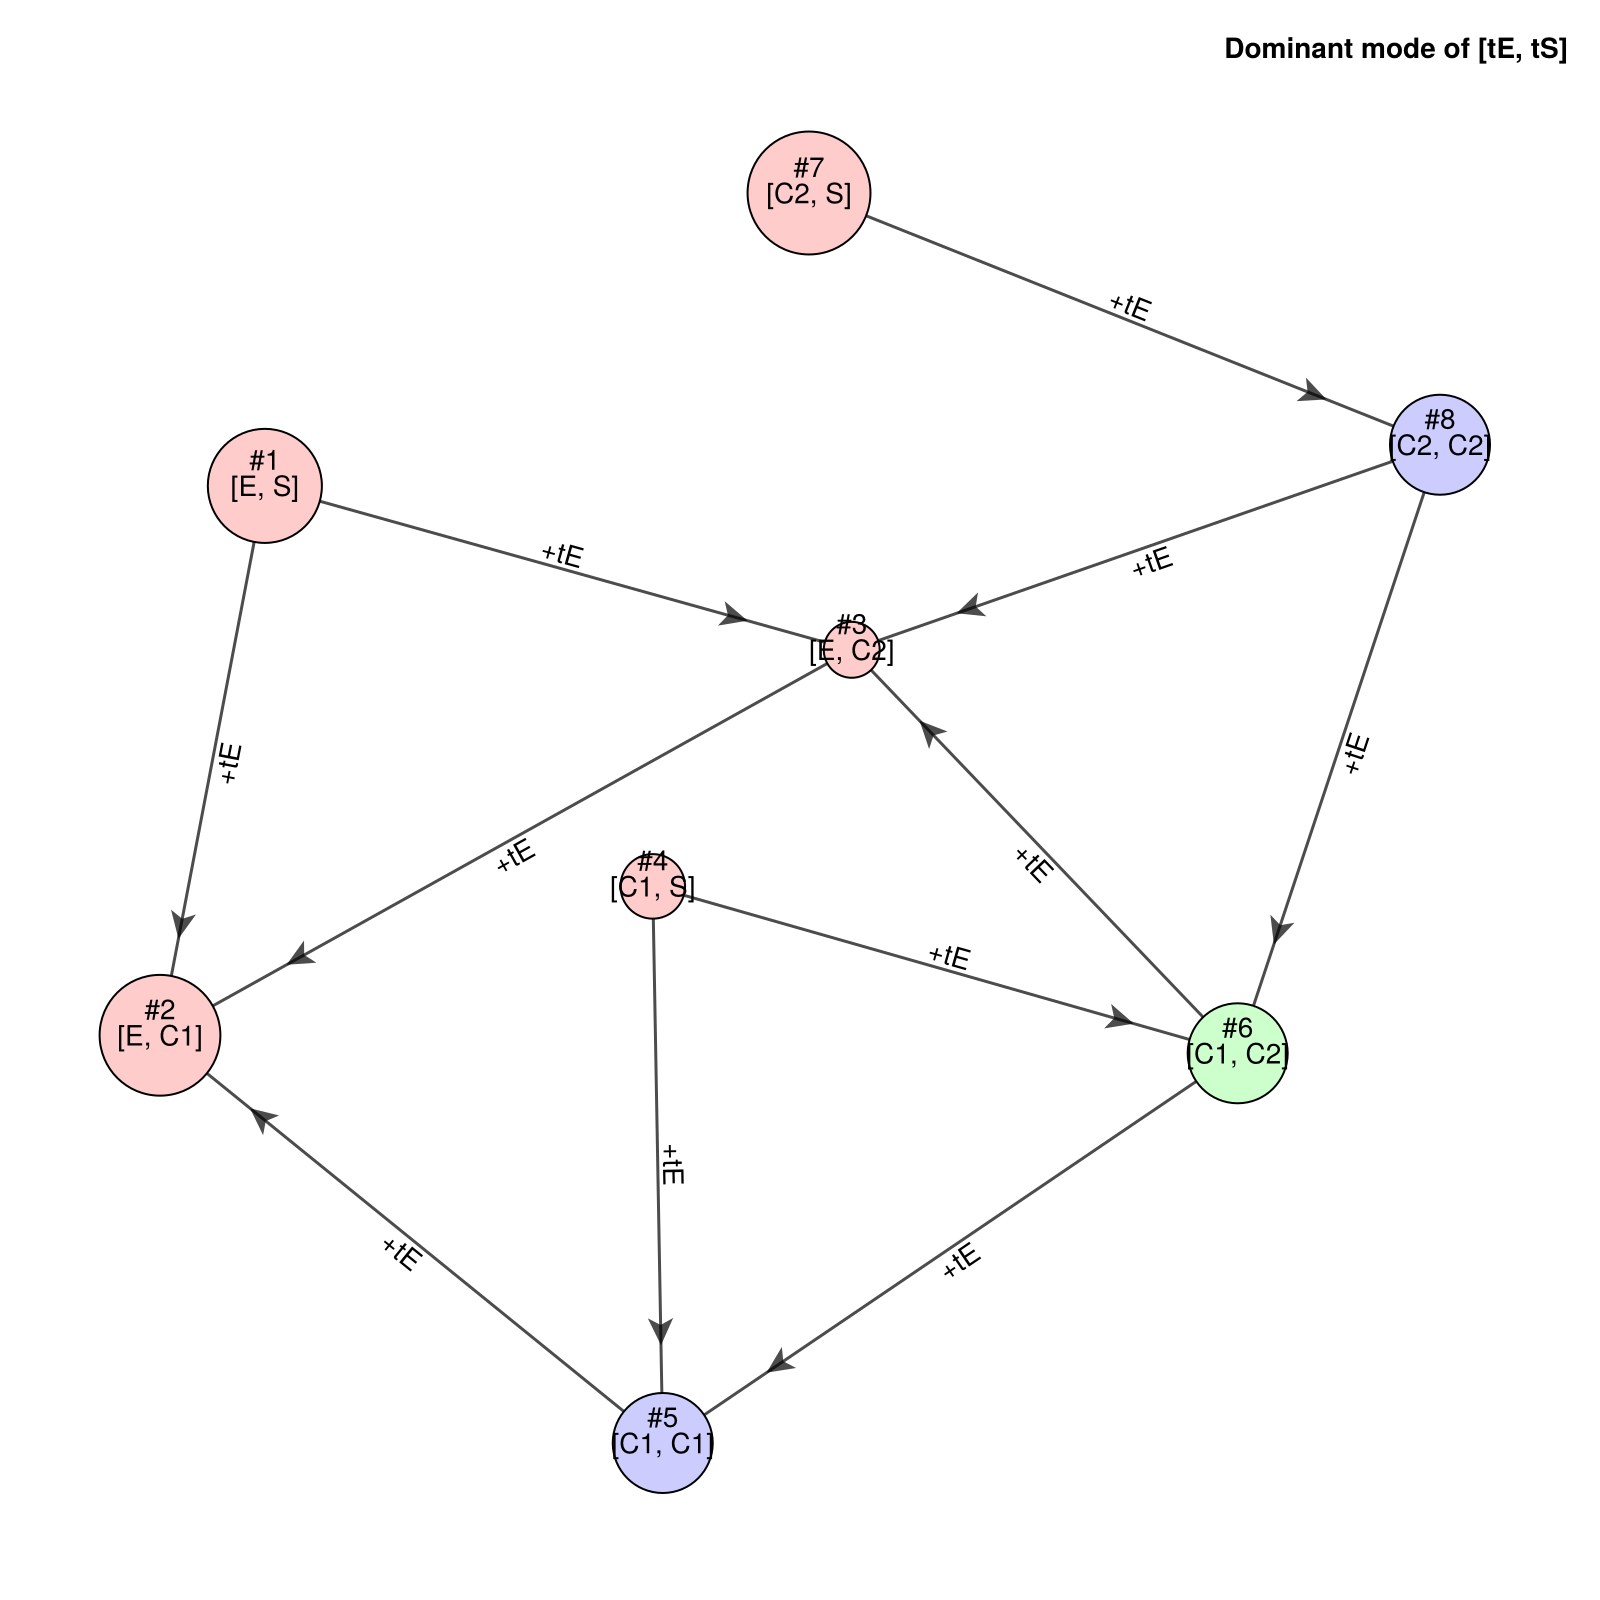

CairoMakie.Screen{IMAGE}


In [60]:
ch_idx_1=1
grh_qK_1 = get_qK_neighbor_grh(model,ch_idx_1)
# edge_labels = get_edge_labels(model, sym=true, half=false) #get_edge_labels of all pairs.
f2,ax2,p2 = draw_qK_neighbor_grh(model,grh_qK_1; 
            figsize=(800,800), 
            edge_labels="+"*repr(model.q_sym[ch_idx_1]),
            node_size=V)
p2.node_pos[] = posi

add_vertices_idx!(ax2,p2)
limits!(ax2, bounds...)
display(f2)
# save("/mnt/e/Pictures/Sequential_binding_network_rgms_qK_add_tE.svg", f2)

In [61]:
pths = find_all_complete_paths(model, grh_qK_1)
render_arrow.(pths,"#") .|>  println
display(model.q_sym[ch_idx_1])

sources = Set([4, 7, 1])
sinks = Set([2])
#1 → #2
#1 → #3 → #2
#4 → #5 → #2
#4 → #6 → #3 → #2
#4 → #6 → #5 → #2
#7 → #8 → #3 → #2
#7 → #8 → #6 → #3 → #2
#7 → #8 → #6 → #5 → #2


tE

In [ ]:
conds = find_conditions_for_pathes(model, pths, ch_idx_1)

8-element Vector{Polyhedron}:
 HalfSpace([1.0, -0.0, -1.0], -0.3010299956639812) ∩ HalfSpace([1.0, -1.0, -0.0], 0.0)
 HalfSpace([1.0, -1.0, -0.0], 0.0) ∩ HalfSpace([2.0, -1.0, -1.0], 0.0) ∩ HalfSpace([-1.0, -0.0, 1.0], 0.3010299956639812)
 HalfSpace([-1.0, 1.0, -0.0], 0.0) ∩ HalfSpace([1.0, -0.0, -1.0], -0.3010299956639812)
 HalfSpace([1.0, -0.0, -1.0], 0.0) ∩ HalfSpace([-1.0, 1.0, -0.0], 0.0) ∩ HalfSpace([-0.0, -1.0, 1.0], 0.3010299956639812)
 HalfSpace([1.0, -0.0, -1.0], 0.0) ∩ HalfSpace([-1.0, -0.0, 1.0], 0.3010299956639812) ∩ HalfSpace([-0.0, 1.0, -1.0], -0.3010299956639812)
 HalfSpace([-2.0, 1.0, 1.0], 0.0) ∩ HalfSpace([-0.0, -1.0, 1.0], 0.0)
 HalfSpace([-3.321928094887362, -0.0, 3.321928094887362], 0.0) ∩ HalfSpace([-0.0, 1.0, -1.0], 0.0) ∩ HalfSpace([-0.0, -1.0, 1.0], 0.3010299956639812)
 HalfSpace([-3.321928094887362, -0.0, 3.321928094887362], 0.0) ∩ HalfSpace([-0.0, 3.321928094887362, -3.321928094887362], -1.0)

In [63]:
V_conds = calc_volume(conds;asymptotic=true,N=1000_0000).|> x->x[1]
V_conds .|> x->round(x, digits=3)|>println

total_counts = [3333517, 834221, 1666492, 0, 0, 2498511, 0, 1667259]
0.333
0.083
0.167
0.0
0.0
0.25
0.0
0.167


8-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

In [71]:
idx_tmp = 1
println("input: "* repr(model.q_sym[ch_idx_1]))
println("output: "* repr(model.x_sym[idx_tmp]))
ord_pth = find_reaction_order_for_pathes(model, pths, ch_idx_1, idx_tmp)
render_arrow.(ord_pth) .|> println

println("Deduplicated:")
ord_pth_ = find_reaction_order_for_pathes(model, pths, ch_idx_1, idx_tmp;deduplicate=true,keep_singular=false)
m = group_sum(ord_pth_, V_conds)
for (k,v) in m
    print(render_arrow(k))
    print("\t")
    println(round(v, digits=3))
end

input: tE
output: E
1 → 1
1 → 1 → 1
1 → Inf → 1
1 → 2 → 1 → 1
1 → 2 → Inf → 1
1 → Inf → 1 → 1
1 → Inf → 2 → 1 → 1
1 → Inf → 2 → Inf → 1
Deduplicated:
1	0.833
1 → 2 → 1	0.167


In [491]:
calc_volume(conds[4],asymptotic=false)

(0.00029791958496452957, 3.377004112228246e-5)

In [73]:
model.N

2×4 Matrix{Int64}:
 1  1  -1   0
 0  1   1  -1

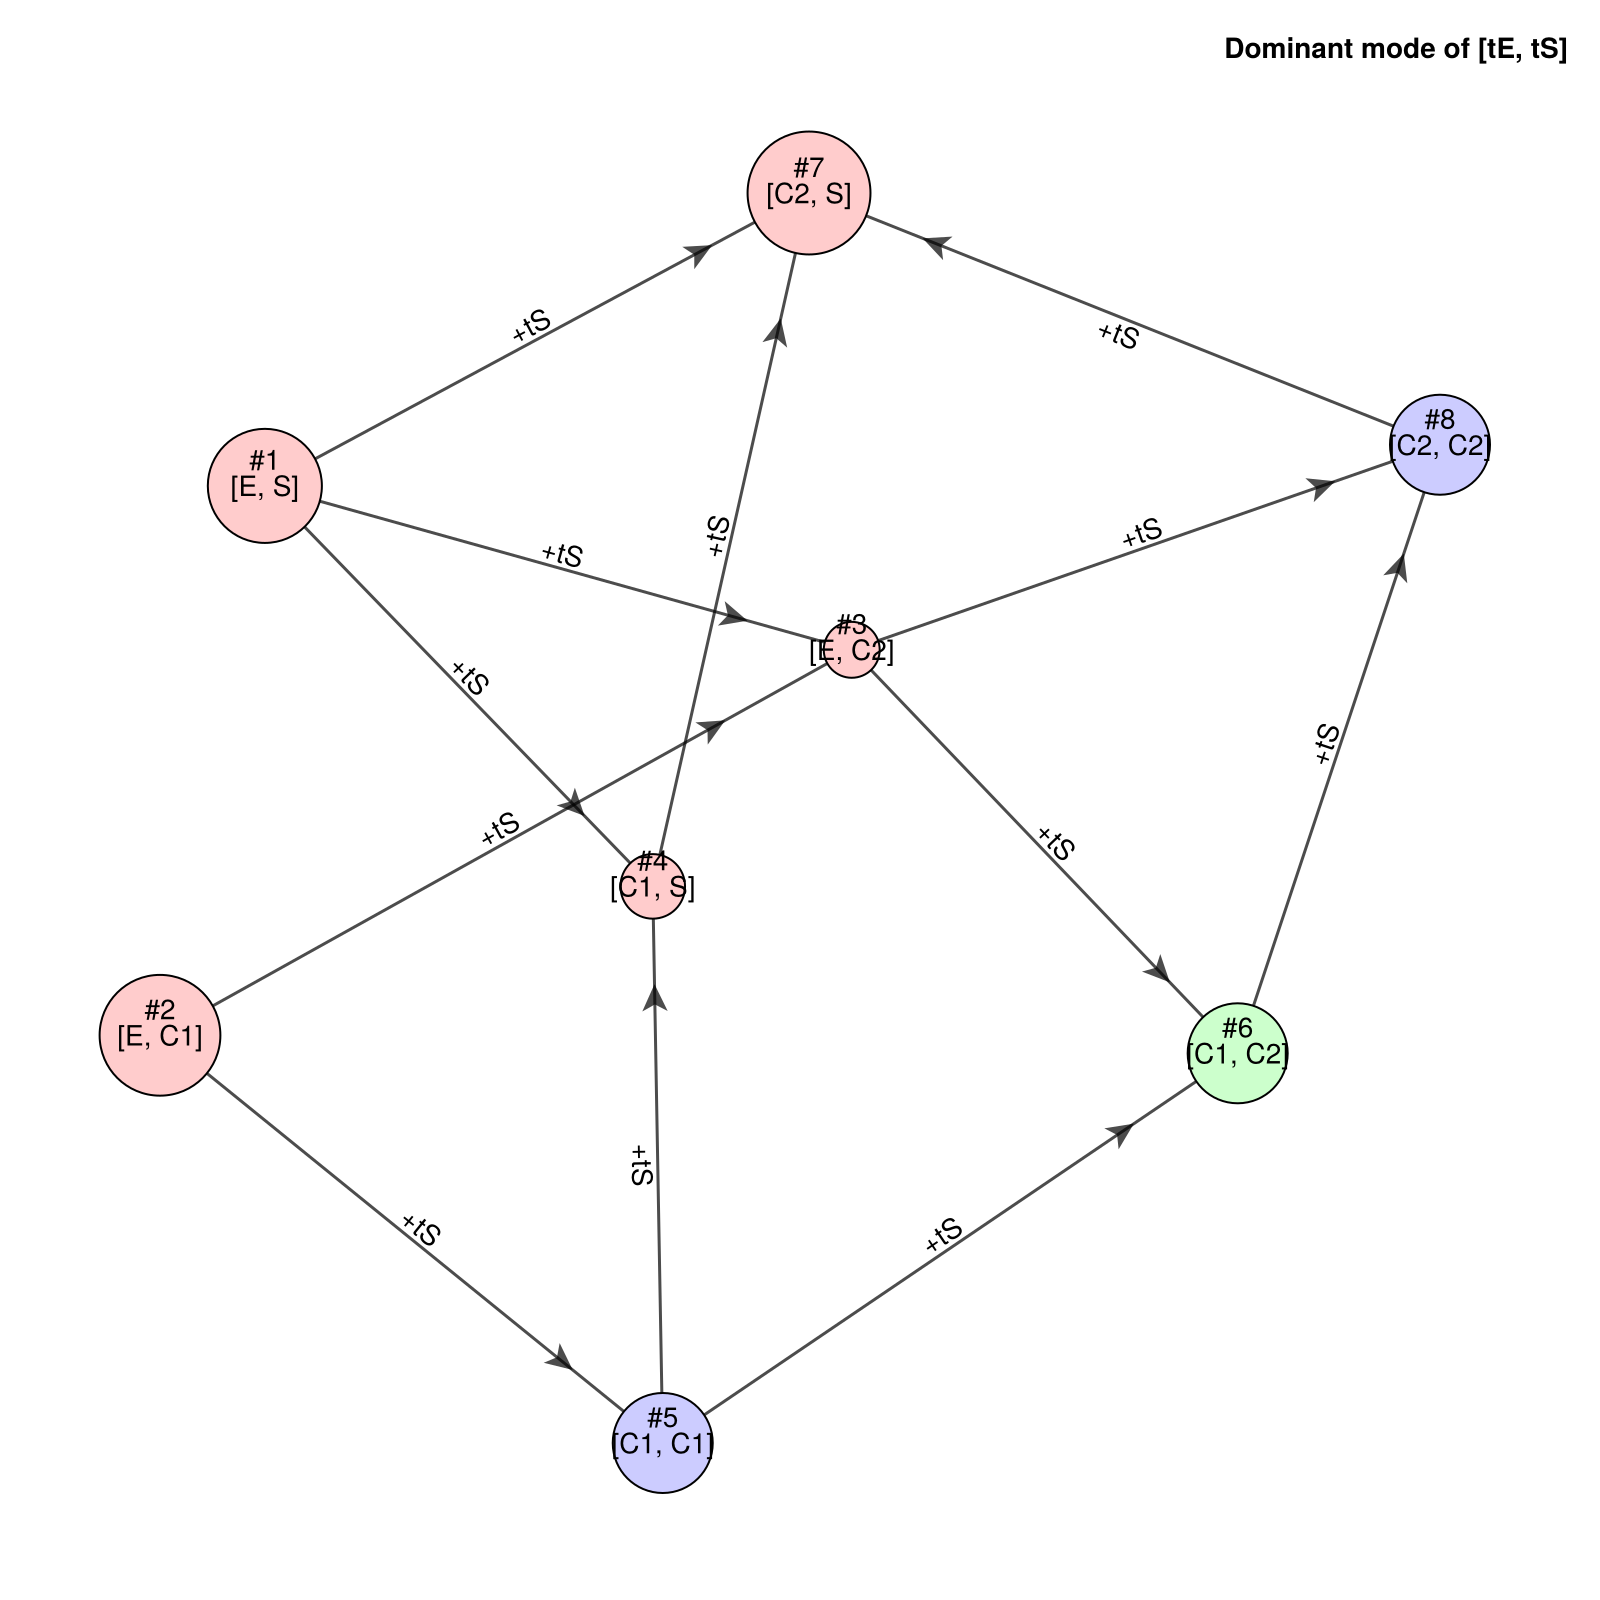

CairoMakie.Screen{IMAGE}


In [11]:
ch_idx_2=2
grh_qK_2 = get_qK_neighbor_grh(model,ch_idx_2)
# edge_labels = get_edge_labels(model, sym=true, half=false) #get_edge_labels of all pairs.
f2,ax2,p2 = draw_qK_neighbor_grh(model,grh_qK_2; 
            figsize=(800,800), 
            edge_labels="+"*repr(model.q_sym[ch_idx_2]),
            node_size=V)
p2.node_pos[] = posi
add_vertices_idx!(ax2,p2)
limits!(ax2, bounds...)
display(f2)
# save("/mnt/e/Pictures/Sequential_binding_network_rgms_qK_add_tS.svg", f2)

In [49]:
pths = find_all_complete_paths(model, grh_qK_2)
render_arrow.(pths,"#") .|>  println
display(model.q_sym[ch_idx_2])

sources = Set([2, 1])
sinks = Set([7])
#1 → #3 → #6 → #8 → #7
#1 → #3 → #8 → #7
#1 → #4 → #7
#1 → #7
#2 → #3 → #6 → #8 → #7
#2 → #3 → #8 → #7
#2 → #5 → #4 → #7
#2 → #5 → #6 → #8 → #7


tS

In [ ]:
conds = find_conditions_for_pathes(model, pths, ch_idx_2)

8-element Vector{Polyhedron}:
 HalfSpace([2.0, -2.0, -0.0], 0.0) ∩ HalfSpace([-1.0, -0.0, 1.0], 0.3010299956639812) ∩ HalfSpace([-0.0, 1.0, -1.0], 0.0)
 HalfSpace([2.0, -2.0, -0.0], 0.0) ∩ HalfSpace([-2.0, 1.0, 1.0], 0.6020599913279624) ∩ HalfSpace([-0.0, -1.0, 1.0], 0.0)
 HalfSpace([1.0, -1.0, -0.0], 0.0) ∩ HalfSpace([-0.0, 1.0, -1.0], 0.0) ∩ HalfSpace([1.0, -0.0, -1.0], -0.3010299956639812)
 HalfSpace([-0.0, -1.0, 1.0], 0.0) ∩ HalfSpace([2.0, -1.0, -1.0], -0.6020599913279624)
 HalfSpace([-1.0, 1.0, -0.0], 0.0) ∩ HalfSpace([-0.0, -1.0, 1.0], 0.3010299956639812) ∩ HalfSpace([-0.0, 1.0, -1.0], 0.0)
 HalfSpace([-2.0, 2.0, -0.0], 0.0) ∩ HalfSpace([-0.0, -1.0, 1.0], 0.0)
 HalfSpace([-1.0, 1.0, -0.0], 0.0) ∩ HalfSpace([1.0, -0.0, -1.0], -0.3010299956639812)
 HalfSpace([-0.0, 3.321928094887362, -3.321928094887362], -1.0) ∩ HalfSpace([-3.321928094887362, -0.0, 3.321928094887362], 1.0)

In [51]:
V_conds = calc_volume(conds;asymptotic=true,N=1000_0000).|> x->x[1]
V_conds .|> x->round(x, digits=3)|>println

total_counts = [0, 832500, 1668203, 2501303, 0, 1666435, 1665586, 1665973]
0.0
0.083
0.167
0.25
0.0
0.167
0.167
0.167


8-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

What about the condition for Hill function n>2

In [52]:
display(pths[4])
show_condition_poly(model,conds[4], ch_idx_2;log_space=false)

2-element Vector{Int64}:
 1
 7

syms = Num[tE, K1, K2]


2-element Vector{Num}:
                K1 > K2
 (0.25K1*K2) > (tE^2.0)

In [58]:
# [1,2,3,4]
idx_tmp = 4
println("input: "* repr(model.q_sym[ch_idx_2]))
println("output: "* repr(model.x_sym[idx_tmp]))
ord_pth = find_reaction_order_for_pathes(model, pths, ch_idx_2, idx_tmp)
render_arrow.(ord_pth) .|> println

println("Deduplicated:")
ord_pth_ = find_reaction_order_for_pathes(model, pths, ch_idx_2, idx_tmp;deduplicate=true,keep_singular=false)
m = group_sum(ord_pth_, V_conds)
for (k,v) in m
    print(render_arrow(k))
    print("\t")
    println(round(v, digits=3))
end

input: tS
output: C2
2 → 1 → 1 → 0 → 0
2 → 1 → 0 → 0
2 → 1 → 0
2 → 0
2 → 1 → 1 → 0 → 0
2 → 1 → 0 → 0
2 → Inf → 1 → 0
2 → Inf → 1 → 0 → 0
Deduplicated:
2 → 1 → 0	0.75
2 → 0	0.25


In [43]:
isinf(-Inf)

true

In [539]:
[model.q_sym;model.K_sym] |> typeof

Vector{Num} (alias for Array{Num, 1})

In [36]:
v = get_interface(model,2,5)

show_sym_conds(v...,[model.q_sym;model.K_sym],1; log_space=false)

1-element Vector{Num}:
 tS ~ tE

### The next part is about make the binding network deeper.

In [113]:
N = [1 1 -1 0 0 0 0
     1 0 1 -1 0 0 0
     1 0 0 1 -1 0 0
     1 0 0 0 1 -1 0
     1 0 0 0 0 1 -1]
model = Bnc(N=N)

Bnc{Int8}([1 1 … 0 0; 1 0 … 0 0; … ; 1 0 … -1 0; 1 0 … 1 -1], [1 0 … 4 5; 0 1 … 1 1], 5, 7, 2, Num[x₁, x₂, x₃, x₄, x₅, x₆, x₇], Num[q₁, q₂], Num[K₁, K₂, K₃, K₄, K₅], nothing, Vector{Int8}[], Dict{Vector{Int8}, Int64}(), Bool[], Int8[], nothing, Vertex[], Bool[], false, Dict{Vector{Int8}, Tuple{SparseMatrixCSC{Float64, Int64}, Int8}}(), -1, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.2041199826559248, 0.7781512503836436, 0.0, 0.0, 0.0, 0.0, 0.0], false, sparse([1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2], [1, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7], [1, 1, 1, 1, 2, 1, 3, 1, 4, 1, 5, 1], 2, 7), sparse([1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2], [1, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 2, 7), [[1, 3, 4, 5, 6, 7], [2, 3, 4, 5, 6, 7]], [1, 6, 11], sparse([1, 2, 3, 4, 5, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5], [1, 1, 1, 1, 1, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7], [1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1], 5, 7), sparse([1, 3, 4, 5, 6, 7, 2, 3, 1, 2  …  2, 5, 6, 1, 2, 6, 7, 1, 2, 7], [1, 1

In [114]:
ch_idx_2=1
idx_tmp = 7

grh_qK_2 = get_qK_neighbor_grh(model,ch_idx_2)
pths = find_all_complete_paths(model, grh_qK_2)
conds = find_conditions_for_pathes(model, pths, ch_idx_2)

---------------------Start finding all vertices, it may takes a while.--------------------
Finished, with 26 vertices found and 16 asymptotic vertices.

-------------Start calculating nullity for each vertex, it also takes a while.------------
1.Building Nρ_inv cache in parallel...
2.Calculating nullity for each vertex in parallel...
3.Storing all vertices information...
Done.
----------------Start calculating vertices neighbor graph, It may takes a while.----------------
Done.

-------Start calculating vertices neighbor graph with qK change dir, It may takes a while.------------
Done.



[ Info: sources: Set([7, 1])
[ Info: sinks: Set([6])


1932-element Vector{Polyhedron}:
 HalfSpace([1.0, -1.0, -0.0, -0.0, -0.0, -0.0], 0.0) ∩ HalfSpace([-0.0, 1.0, -1.0, -0.0, -0.0, -0.0], 0.0) ∩ HalfSpace([1.0, -0.0, -1.0, -0.0, -0.0, -0.0], -0.3010299956639812) ∩ HalfSpace([1.0, -0.0, -0.0, -1.0, -0.0, -0.0], -0.47712125471966244) ∩ HalfSpace([-0.0, -0.0, 1.0, -1.0, -0.0, -0.0], 0.0) ∩ HalfSpace([-0.0, -0.0, -0.0, 1.0, -1.0, -0.0], 0.0) ∩ HalfSpace([1.0, -0.0, -0.0, -0.0, -1.0, -0.0], -0.6020599913279624) ∩ HalfSpace([-0.0, -0.0, -0.0, -0.0, 1.0, -1.0], 0.0) ∩ HalfSpace([1.0, -0.0, -0.0, -0.0, -0.0, -1.0], -0.6989700043360187)
 HalfSpace([1.0, -0.0, -1.0, -0.0, -0.0, -0.0], -0.3010299956639812) ∩ HalfSpace([1.0, -1.0, -0.0, -0.0, -0.0, -0.0], 0.0) ∩ HalfSpace([1.0, -0.0, -0.0, -1.0, -0.0, -0.0], -0.47712125471966244) ∩ HalfSpace([-0.0, 1.0, -1.0, -0.0, -0.0, -0.0], 0.0) ∩ HalfSpace([-0.0, -0.0, 1.0, -1.0, -0.0, -0.0], 0.0) ∩ HalfSpace([-0.0, -0.0, -0.0, 2.0, -1.0, -1.0], 0.0) ∩ HalfSpace([-0.0, -0.0, -0.0, -0.0, -1.0, 1.0], 0.0) ∩ HalfS

In [119]:
V_conds = calc_volume(conds;asymptotic=true).|> x->x[1]
V_conds .|> x->round(x, digits=3)|>println
sum(V_conds)

length(full_dim_idx) = 120


[ Info: Number of polyhedra to calc volume: 120


0.001
0.003
0.0
0.0
0.005
0.009
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.006
0.011
0.0
0.0
0.018
0.034
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.005
0.009
0.0
0.0
0.017
0.031
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.018
0.035
0.0
0.0
0.057
0.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

[ Info: Reached time limit (40.26 s). Stopping.
[ Info: Total samples: 7800000, Elapsed: 40.26 s


1.000160790030956

In [127]:
max_poss_idx = sortperm(V_conds;rev=true)[1]

150

In [128]:
ord_pth[max_poss_idx]

2-element Vector{Float64}:
 5.0
 0.0

In [131]:
pths[max_poss_idx]

2-element Vector{Int64}:
 1
 6

In [132]:
(expr_pth, edge_pth) = get_expression_for_path(model, pths[max_poss_idx], ch_idx_2, idx_tmp)

(SymbolicUtils.BasicSymbolic{Real}[((q₁^5.0)*q₂) / (K₁*K₂*K₃*K₄*K₅), q₂], SymbolicUtils.BasicSymbolic{Real}[(K₁^0.2)*(K₂^0.2)*(K₃^0.2)*(K₄^0.2)*(K₅^0.2)])

In [135]:
expr_pth .|> display

((q₁^5.0)*q₂) / (K₁*K₂*K₃*K₄*K₅)

q₂

2-element Vector{Nothing}:
 nothing
 nothing

In [136]:
edge_pth.|> display

(K₁^0.2)*(K₂^0.2)*(K₃^0.2)*(K₄^0.2)*(K₅^0.2)

1-element Vector{Nothing}:
 nothing

In [122]:
ord_pth = find_reaction_order_for_pathes(model, pths, ch_idx_2, idx_tmp)
# render_arrow.(ord_pth) .|> println

println("Deduplicated:")
ord_pth_ = find_reaction_order_for_pathes(model, pths, ch_idx_2, idx_tmp;
            deduplicate=true,keep_singular=false,keep_nonasymptotic=false)
m = group_sum(ord_pth_, V_conds)
collect(m)
for (k,v) in m
    print(render_arrow(k))
    print("\t")
    println(round(v, digits=3))
end

Deduplicated:
5 → 0	0.228
5 → 1 → 0	0.161
5 → 4 → 0	0.068
5 → 2.5 → 0	0.058
5 → 2 → 0	0.047
5 → 3 → 0	0.04
5 → 4 → 1 → 0	0.037
5 → 1.25 → 1 → 0	0.032
5 → 1.667 → 0	0.03
5 → 2.5 → 1 → 0	0.027
5 → 2 → 1 → 0	0.025
5 → 1.25 → 0	0.023
5 → 4 → 2 → 0	0.022
5 → 3 → 1 → 0	0.022
5 → 4 → 3 → 0	0.019
5 → 2.5 → 3 → 0	0.018
5 → 1.667 → 2 → 0	0.015
5 → 1.667 → 1 → 0	0.014
5 → 3 → 2 → 0	0.012
5 → 4 → 2 → 1 → 0	0.011
5 → 2.5 → 1.667 → 0	0.01
5 → 4 → 3 → 1 → 0	0.01
5 → 2.5 → 3 → 1 → 0	0.009
5 → 1.667 → 2 → 1 → 0	0.008
5 → 2.5 → 1.25 → 0	0.007
5 → 3 → 2 → 1 → 0	0.006
5 → 4 → 3 → 2 → 0	0.005
5 → 2.5 → 2 → 0	0.005
5 → 2.5 → 3 → 2 → 0	0.005
5 → 2.5 → 1.25 → 1 → 0	0.005
5 → 2.5 → 1.667 → 1 → 0	0.003
5 → 1.667 → 1.25 → 0	0.003
5 → 4 → 3 → 2 → 1 → 0	0.003
5 → 2.5 → 2 → 1 → 0	0.003
5 → 2.5 → 3 → 2 → 1 → 0	0.003
5 → 1.667 → 1.25 → 1 → 0	0.003
5 → 2.5 → 1.667 → 2 → 0	0.003
5 → 2.5 → 1.667 → 2 → 1 → 0	0.001
5 → 2.5 → 1.667 → 1.25 → 0	0.001
5 → 2.5 → 1.667 → 1.25 → 1 → 0	0.0


In [ ]:
mmm[15][1]

5-element Vector{Float64}:
 5.0
 1.667
 2.0
 1.0
 0.0

In [ ]:
idxs = findall(==(mmm[15][1]),ord_pth_)

48-element Vector{Int64}:
  633
  635
  636
  637
  638
  639
  640
  641
  642
  667
  668
  669
  670
    ⋮
 1750
 1751
 1752
 1753
 1754
 1779
 1781
 1782
 1783
 1784
 1785
 1786

In [ ]:
findmax(V_conds[idxs])

(0.005609899179213663, 46)

In [ ]:
idx = idxs[46]

1784

In [ ]:
display(pths[1784])
show_condition_poly(model,conds[1784], ch_idx_2;log_space=false)

8-element Vector{Int64}:
  7
 12
 15
 19
 20
 25
 26
  6

syms = Num[q₂, K₁, K₂, K₃, K₄, K₅]


6-element Vector{Num}:
                             (0.9999999999999998(K₃^2.220446049250313e-16)*(q₂^2.9999999999999996)) > (K₁^2.9999999999999996)
 (0.4218749999999998(K₂^2.9999999999999996)*(q₂^4.440892098500626e-16)) > ((K₁^4.440892098500626e-16)*(K₃^2.999999999999999))
                                                            (0.9999999999999999(K₁^2.0)) > (K₂*K₃*(q₂^2.220446049250313e-16))
                      (0.1(K₄^8.003922779651102)) > ((K₁^2.6679742598837004)*(K₂^2.6679742598837004)*(K₃^2.6679742598837004))
                                                                                                  (0.8000000000000002K₅) > K₄
                                                                                                   (5.000000000000001q₂) > K₅

2-element Vector{Int64}:
 0
 0

syms = Num[q₂, K₁, K₂, K₃, K₄, K₅]


6-element Vector{Num}:
                             (0.9999999999999998(K₃^2.220446049250313e-16)*(q₂^2.9999999999999996)) > (K₁^2.9999999999999996)
 (0.4218749999999998(K₂^2.9999999999999996)*(q₂^4.440892098500626e-16)) > ((K₁^4.440892098500626e-16)*(K₃^2.999999999999999))
                                                            (0.9999999999999999(K₁^2.0)) > (K₂*K₃*(q₂^2.220446049250313e-16))
                      (0.1(K₄^8.003922779651102)) > ((K₁^2.6679742598837004)*(K₂^2.6679742598837004)*(K₃^2.6679742598837004))
                                                                                                  (0.8000000000000002K₅) > K₄
                                                                                                   (5.000000000000001q₂) > K₅

change_sym = "logq₁"
target_sym = "logx₇"


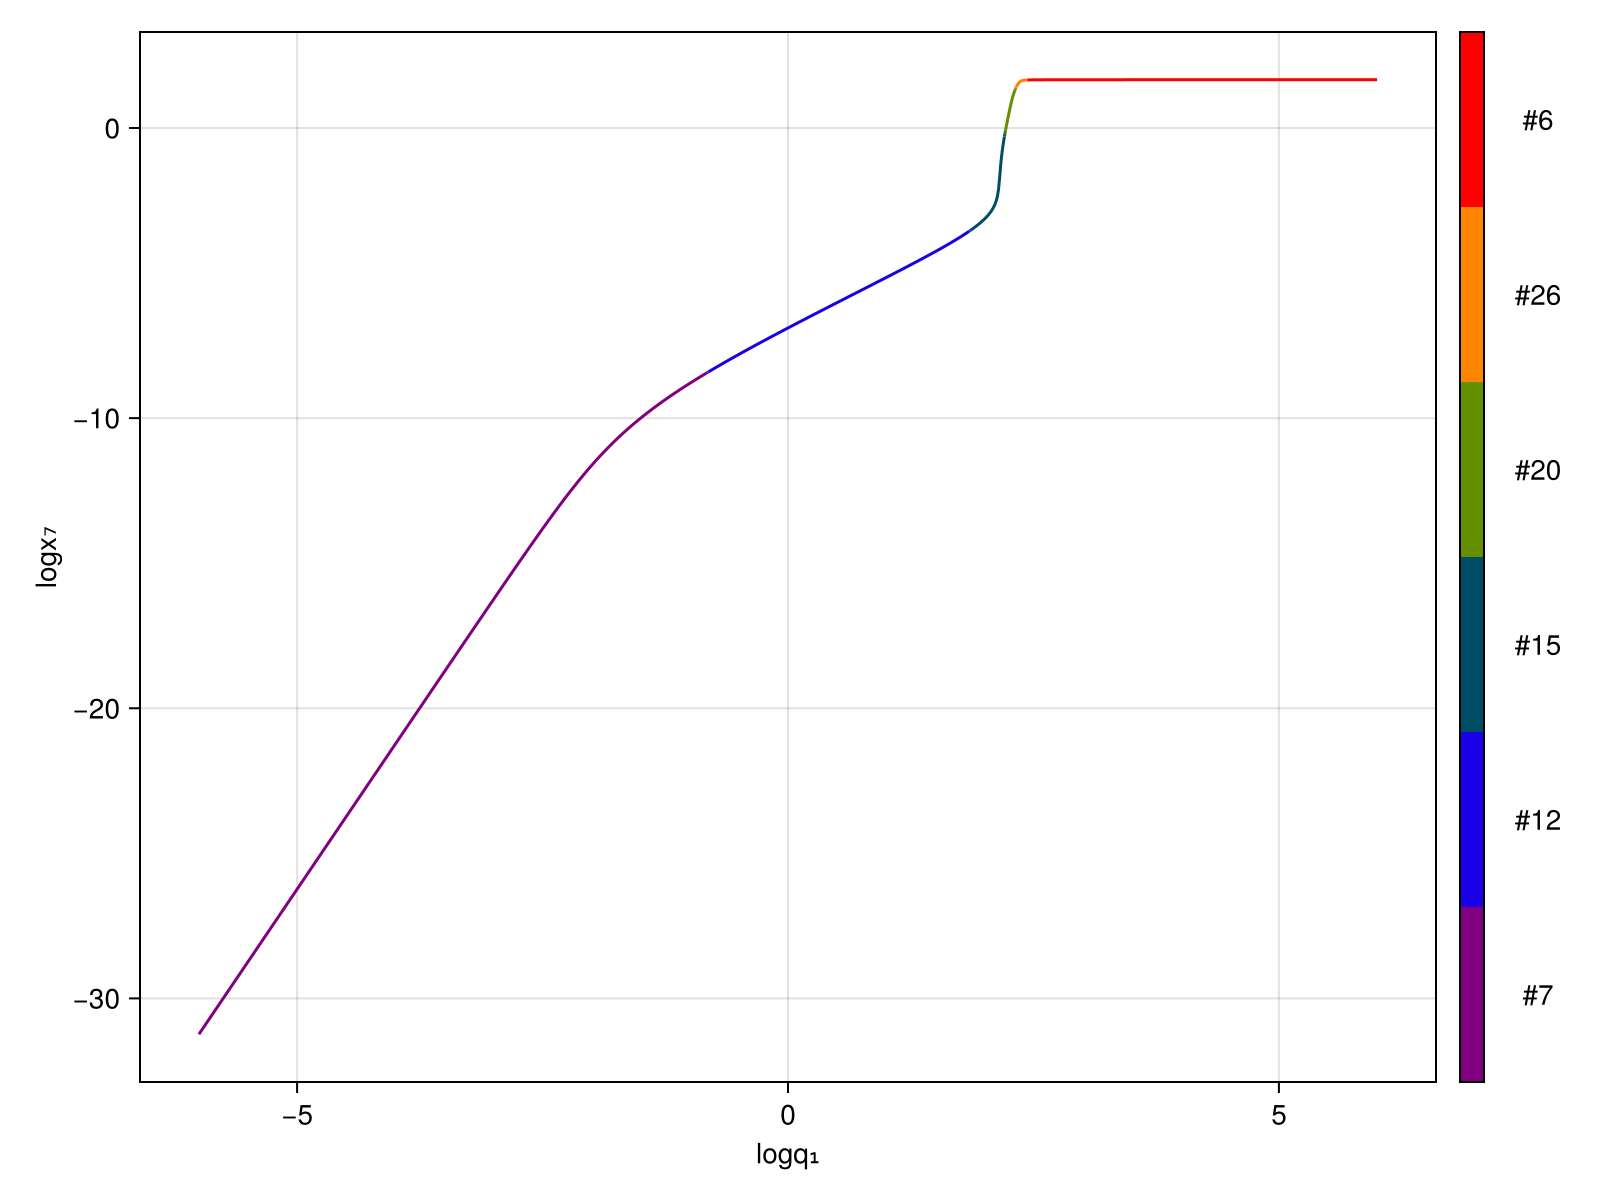

In [ ]:
cond_s = get_one_inner_point(conds[1784],extend=6,rand_line=false, rand_ray=false)
display(show_condition_poly(model,conds[1784], ch_idx_2;log_space=false))
F = SISO_plot(model, cond_s, ch_idx_2; draw_idx=[7],npoints=1000,start=-6, stop=6,cmap=:rainbow, size = (800,600))

In [ ]:
save("/mnt/e/Pictures/Sequential_binding_n_5_example.svg", F)

CairoMakie.Screen{SVG}


In [ ]:
s_perm = (collect(m) .|> x->x[2] )|> x->sortperm(x; rev=true)
mmm = collect(m)[s_perm][1:34]
for (k,v) in mmm
    print(render_arrow(k))
    print("\t")
    println(round(v, digits=3))
end

5 → 1 → 0	0.188
5 → 0	0.1
5 → 4 → 0	0.067
5 → 4 → 1 → 0	0.056
5 → 1.25 → 1 → 0	0.055
5 → 2 → 1 → 0	0.05
5 → 2.5 → 1 → 0	0.048
5 → 2 → 0	0.044
5 → 1.333 → 1 → 0	0.037
5 → 3 → 0	0.031
5 → 1.667 → 1 → 0	0.03
5 → 4 → 3 → 0	0.028
5 → 4 → 2 → 0	0.022
5 → 2.5 → 1.5 → 1 → 0	0.022
5 → 1.667 → 2 → 1 → 0	0.022
5 → 4 → 3 → 1 → 0	0.019
5 → 2.5 → 3 → 1 → 0	0.019
5 → 2.5 → 3 → 0	0.018
5 → 3 → 1 → 0	0.017
5 → 1.667 → 2 → 0	0.015
5 → 4 → 2 → 1 → 0	0.012
5 → 4 → 1.5 → 1 → 0	0.012
5 → 2.5 → 1.25 → 1 → 0	0.011
5 → 2.5 → 3 → 2 → 1 → 0	0.011
5 → 4 → 3 → 2 → 0	0.011
5 → 2.5 → 3 → 2 → 0	0.01
5 → 3 → 2 → 0	0.009
5 → 2.5 → 1.667 → 1 → 0	0.009
5 → 4 → 3 → 2 → 1 → 0	0.008
5 → 2.5 → 1.667 → 2 → 1 → 0	0.006
5 → 1.667 → 1.25 → 1 → 0	0.006
5 → 3 → 2 → 1 → 0	0.005
5 → 2.5 → 1.667 → 2 → 0	0.003
5 → 2.5 → 1.667 → 1.25 → 1 → 0	0.001


In [ ]:
model.L

2×7 Matrix{Int64}:
 1  0  1  2  3  4  5
 0  1  1  1  1  1  1

The next question is if we can constrain the K such that we can constrain the system within some regimes and remove the others.

Still let's use the level 2 binding network as an example

In [ ]:
N= [1 1 -1 0
    0 1  1 -1]
L = L_from_N(N)
x_sym = [:E,:S,:C1,:C2]
q_sym = [:tE,:tS]
K_sym = [:K1,:K2]
model = Bnc(N=N,L=L,q_sym=q_sym,x_sym=x_sym,K_sym=K_sym)
find_all_vertices!(model)
summary(model)

---------------------Start finding all vertices, it may takes a while.--------------------
Finished, with 8 vertices found and 7 asymptotic vertices.

-------------Start calculating nullity for each vertex, it also takes a while.------------
1.Building Nρ_inv cache in parallel...
2.Calculating nullity for each vertex in parallel...
3.Storing all vertices information...
Done.
----------Binding Network Summary:-------------
Number of species (n): 4
Number of conserved quantities (d): 2
Number of reactions (r): 2
L matrix: [1 0 1 1; 0 1 1 2]
N matrix: [1 1 -1 0; 0 1 1 -1]
Direction of binding reactions: forward
Catalysis involved: No
Regimes constructed: Yes
Number of regimes: 8
  - Invertible + Asymptotic: 5
  - Singular +  Asymptotic: 2
  - Invertible +  Non-Asymptotic: 1
  - Singular +  Non-Asymptotic: 0
-----------------------------------------------


In [ ]:
C_add = [0 0 ]